In [1]:
import csv

import pandas as pd

import numpy as np

import torch

from torch import nn, optim

from torch.autograd import Variable

from torch.utils.data import Dataset

from torch.utils.data import DataLoader

import time

import matplotlib.pyplot as plt

In [2]:
# 定义自己的类
class MyDataset(Dataset):
    
    # 初始化
    def __init__(self, file_name):
        # 读入数据
        self.data = pd.read_csv(file_name)
    
    # 返回df的长度
    def __len__(self):
        return len(self.data)
    
    # 获取第idx+1列的数据
    def __getitem__(self, idx):
        return self.data.values[idx,1:10]

# 通过实例化对象来访问该类
# 假设同目录下存在名为median_benchmark.csv的文件
ds = MyDataset('formatweather.csv')
ds=np.asarray(ds[:], dtype = np.float32)#####源文件float32 ,不知道为什么读取变为float64，这里再进行处理  最大最小化时变化
##dl = DataLoader(ds, batch_size=100, shuffle=False)

#####处理为torch，分为trainx，trainy
torchds=torch.from_numpy(ds[:])

In [3]:
# 定义 Recurrent Network 模型

class Rnn(nn.Module):

    def __init__(self, in_dim, hidden_dim, n_layer, n_class):

        super(Rnn, self).__init__()

        self.n_layer = n_layer

        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(in_dim, hidden_dim, n_layer, batch_first=True)

        self.classifier = nn.Linear(hidden_dim, n_class)



    def forward(self, x):

        # h0 = Variable(torch.zeros(self.n_layer, x.size(1),

        #   self.hidden_dim)).cuda()

        # c0 = Variable(torch.zeros(self.n_layer, x.size(1),

        #   self.hidden_dim)).cuda()

        out, _ = self.lstm(x) #out 100 28 128 _ [0]2 100 128 [1]2 100 128

        out = out[:, -1, :]  #100,128

        out = self.classifier(out) #100,10

        return out


In [4]:
class Cnn(nn.Module):

    def __init__(self, in_dim, n_class):

        super(Cnn, self).__init__()

        self.conv = nn.Sequential(

            nn.Conv2d(in_dim, 6, (1,2), stride=(1), padding=(0,1)),#6,1,9

            nn.ReLU(True),

            nn.MaxPool2d(1, 1),#6,1,9

            nn.Conv2d(6, 16, (1,3), stride=(1), padding=(0,1)),

            nn.ReLU(True), nn.MaxPool2d(1, 1))#16,1,9
   
            #5*144

        self.fc = nn.Linear(144, 16)
        
        self.fc1 = nn.Linear(16, 3)
        
        self.fc2 = nn.Linear(3, n_class)



    def forward(self, x):

        out = self.conv(x)

        out = out.view(out.size(0), -1)

        out = self.fc(out)
        
        out1=self.fc1(out)
        
        out=self.fc2(out1)

        return out1

In [5]:
cnnmodel = Cnn(1, 1)
cnnmodel.load_state_dict(torch.load('./weathercnn-0.01-true-7.18.pth'))


cnnmodel.eval()
    
#test_x=torchds[:30700,0:8]
test_x=torchds[:30700,0:8]

test_x=test_x.view(-1,1,1,8)

#test_y=torchds[:30700,8]
test_y=torchds[:30700,8]

test_y=test_y.view(-1,1)

test_x=Variable(test_x)

test_y=Variable(test_y)

cnnout = cnnmodel(test_x) #####8

In [6]:
cnnout.size()

torch.Size([30700, 3])

In [7]:
rnnmodel = Rnn(3, 5, 2, 1)  
##model.load_state_dict(torch.load('./weathercnn.pth'))
criterion = nn.MSELoss()
optimizer = optim.SGD(rnnmodel.parameters(), lr=0.1) ####速度很快

In [9]:
print(cnnout[1500:1510],test_y[1500:1510])

tensor([[-0.2014, -0.2062, -0.0376],
        [-0.1936, -0.2219, -0.0433],
        [-0.1866, -0.2360, -0.0484],
        [-0.1999, -0.2114, -0.0386],
        [-0.1990, -0.2161, -0.0326],
        [-0.2030, -0.2086, -0.0313],
        [-0.1904, -0.2364, -0.0436],
        [-0.1820, -0.2494, -0.0505],
        [-0.1838, -0.2382, -0.0465],
        [-0.1837, -0.2360, -0.0472]], grad_fn=<SliceBackward>) tensor([[0.2384],
        [0.2535],
        [0.2274],
        [0.2324],
        [0.2233],
        [0.2475],
        [0.2626],
        [0.2575],
        [0.2565],
        [0.2646]])


In [27]:
cnn_lstm_train=torch.cat([cnnout,test_y],dim=1) 
cnn_lstm_train[1500:1510]

tensor([[-0.2014, -0.2062, -0.0376,  0.2384],
        [-0.1936, -0.2219, -0.0433,  0.2535],
        [-0.1866, -0.2360, -0.0484,  0.2274],
        [-0.1999, -0.2114, -0.0386,  0.2324],
        [-0.1990, -0.2161, -0.0326,  0.2233],
        [-0.2030, -0.2086, -0.0313,  0.2475],
        [-0.1904, -0.2364, -0.0436,  0.2626],
        [-0.1820, -0.2494, -0.0505,  0.2575],
        [-0.1838, -0.2382, -0.0465,  0.2565],
        [-0.1837, -0.2360, -0.0472,  0.2646]], grad_fn=<SliceBackward>)

In [28]:
dltrain=DataLoader(cnn_lstm_train, batch_size=100, shuffle=True)

In [34]:
#%%time 
losslist,evallosslist,accuracylist=[],[],[]

start = time.clock()
for epoch in range(100):
 
    print('epoch {}'.format(epoch + 1))

    print('*' * 10)

    running_loss = 0.0
    
    #dldata=zip(dltrain,dltest)  #cnnout,trainy0.7

    for i, data in enumerate(dltrain, 1):
        
            train_x=data[:,:3]
            
            train_x=train_x.view(-1,1,3)
            
            train_y=data[:,3]
            
            train_y=train_y.view(-1,1)
            
            train_x=Variable(train_x)
            
            train_y=Variable(train_y)
        
            out = rnnmodel(train_x)

            loss = criterion(out, train_y)
            
            running_loss += loss.item() * train_y.size(0)
            

            # 向后传播

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
            
    losslist.append(running_loss / (len(cnn_lstm_train)))   
    ######进入评估模式
    rnnmodel.eval()
    
    test_x=torchds[30700:,0:8]

    test_x=test_x.view(-1,1,1,8)

    test_y=torchds[30700:,8]

    test_y=test_y.view(-1,1)

    test_x=Variable(test_x)

    test_y=Variable(test_y)

    testout = cnnmodel(test_x)

    testout=testout.view(-1,1,3)

    evalout=rnnmodel(testout)
    
    evalloss = criterion(evalout, test_y)
    
    evalrunning_loss = evalloss.item()## * test_y.size(0)
    
    ###evallist
    
    evallosslist.append(evalrunning_loss)
    
    ####计算准确率
    acc=0
    for i in range(13123):
        x=test_y.numpy()[i]-evalout.detach().numpy()[i]
        if abs(x)<=0.02:
            acc+=1
    accuracy_rate=acc/13123
    #print(accuracy_rate)
    ##accuracylist
    accuracylist.append(accuracy_rate)
                
    print('{0} {1} {2}'.format(running_loss / 30700,evalrunning_loss,accuracy_rate))   
    ##0.0007136262848905776 0.000537822546903044 0.823211155985674
    #print('running_loss:-------')
    #print(running_loss / (len(cnn_lstm_train)))  
print(time.clock()-start) #117.3018567  2-293.7432698  246.2105962 ## 169.9473958999988

I:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


epoch 1
**********
0.008194582209185203 0.008008957840502262 0.16901623104473062
epoch 2
**********
0.008188255716734096 0.008116665296256542 0.16215804313038176
epoch 3
**********
0.008180230156691436 0.007975800894200802 0.16970204983616552
epoch 4
**********
0.00817010514529161 0.007949642837047577 0.1769412481902004
epoch 5
**********
0.008154755620534625 0.007927429862320423 0.17968452335593996
epoch 6
**********
0.008146513683466599 0.007944012992084026 0.17107368741903528
epoch 7
**********
0.008137368193618249 0.00793108157813549 0.17252152708984225
epoch 8
**********
0.008121884609982128 0.007908300496637821 0.17541720643145622
epoch 9
**********
0.00811035130309481 0.007906800135970116 0.16970204983616552
epoch 10
**********
0.008093482135197432 0.00786602683365345 0.17808427950925856
epoch 11
**********
0.008074914699826838 0.007872105576097965 0.16977825192410273
epoch 12
**********
0.008052356507786905 0.007811174727976322 0.18151337346643298
epoch 13
**********
0.00802953

0.0007136262848905776 0.000537822546903044 0.823211155985674


I:\Anaconda\lib\site-packages\ipykernel_launcher.py:88: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


169.9473958999988


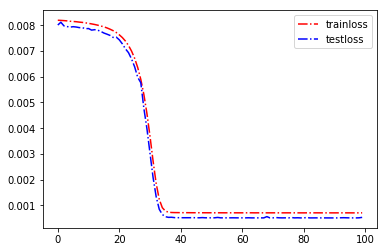

In [35]:
plt.plot(losslist,'r-.',label='trainloss') 
plt.plot(evallosslist,'b-.',label='testloss') 
plt.legend(loc='best')#显示在最好的位置
plt.show()

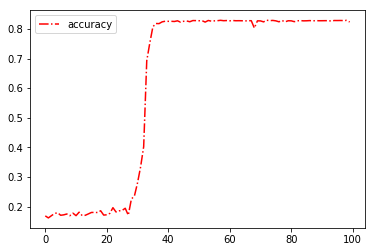

In [36]:
plt.plot(accuracylist,'r-.',label='accuracy') 
plt.legend(loc='best')#显示在最好的位置
plt.show()

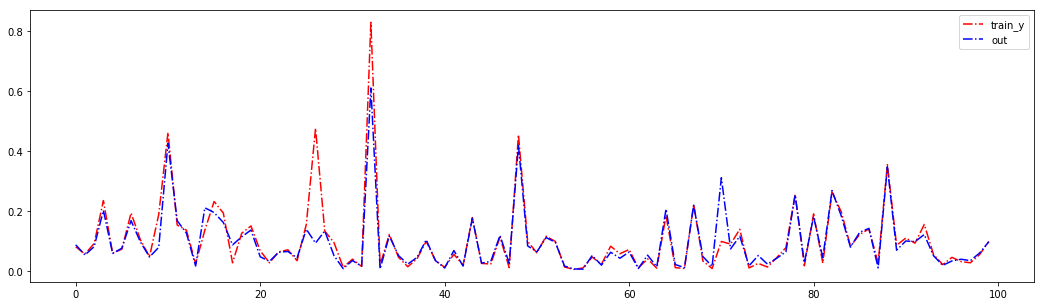

In [37]:
x=range(0,100)
plt.figure(num=1,figsize=(18,5))#定义编号为1 大小为(8,5)
plt.plot(x,train_y.detach().numpy(),'r-.',label='train_y') 
plt.plot(x,out.detach().numpy(),'b-.',label='out') 
plt.legend(loc='best')#显示在最好的位置
plt.show()

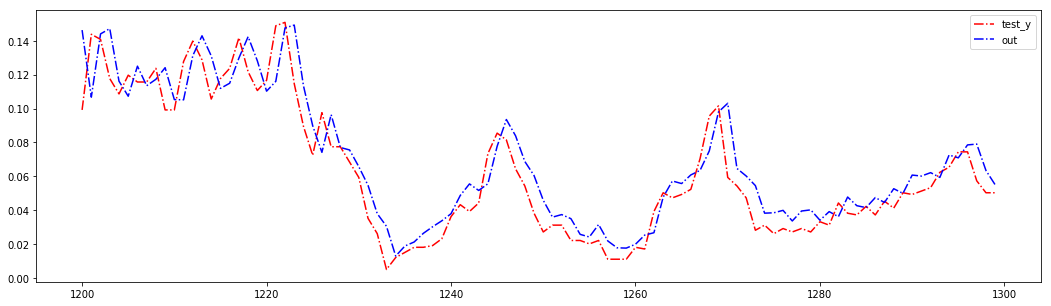

In [39]:
#x=range(0,13123)
x=range(1200,1300)
plt.figure(num=1,figsize=(18,5))#定义编号为1 大小为(8,5)
plt.plot(x,test_y.detach().numpy()[1200:1300],'r-.',label='test_y') 
plt.plot(x,evalout.detach().numpy()[1200:1300],'b-.',label='out') 
plt.legend(loc='best')#显示在最好的位置
plt.show()

In [40]:
# 保存模型
torch.save(rnnmodel.state_dict(), './weathercnn-lstm-0.1-true-7.18.pth')